<a href="https://colab.research.google.com/github/cspringbett/octomatic/blob/main/octomatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import os
import json
import hashlib
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0, InceptionV3, MobileNetV3Large
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard
import datetime

Set Directories and kFold Configuration

In [ ]:
DATASET_ZIP_PATH = "/content/drive/MyDrive/OctoMatic_SpeciesID/octopus_dataset.zip"
EXTRACT_DIR = "/content/octopus_dataset"
N_SPLITS = 5
EPOCHS = 5
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CONFIDENCE_THRESHOLD = 0.8
OUTPUT_DIR = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)



Clear previous hash data, do not run after timeout

In [ ]:
# import os, glob, shutil

# OUTPUT_DIR = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"

# patterns = [
#     "*_results.json",
#     "*_probs.json",          # NEW
#     "*_history.json",        # NEW
#     "*_dataset_hash.txt",
#     "*.h5",                # uncomment to also remove models
# ]

# for pat in patterns:
#     for p in glob.glob(os.path.join(OUTPUT_DIR, pat)):
#         try:
#             os.remove(p)
#             print("🗑️  removed:", p)
#         except FileNotFoundError:
#             pass

# # Optional extras:
# for d in ["logs", "eval_figs", "eval_figs_folds"]:
#     path = os.path.join(OUTPUT_DIR, d)
#     if os.path.isdir(path):
#         shutil.rmtree(path, ignore_errors=True)
#         print("🗑️  removed dir:", path)


UnZip Dataset

In [ ]:
import shutil
import os

# Clear previous data
!rm -rf /content/tmp /content/octopus_dataset
!unzip -q "{DATASET_ZIP_PATH}" -d /content/tmp
!mkdir -p /content/octopus_dataset

# Move all valid species folders to /content/octopus_dataset
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
src_root = "/content/tmp"
dst_root = "/content/octopus_dataset"

moved_dirs = 0
for root, dirs, files in os.walk(src_root):
    if any(file.lower().endswith(valid_exts) for file in files):
        species_name = os.path.basename(root)
        dest_path = os.path.join(dst_root, species_name)
        if not os.path.exists(dest_path):
            shutil.move(root, dest_path)
            moved_dirs += 1

print(f"✅ Moved {moved_dirs} species folders to {dst_root}")


✅ Moved 5 species folders to /content/octopus_dataset


In [ ]:
from pathlib import Path

# Supported extensions (lowercase)
supported_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

# Collect all image files recursively, case-insensitive
image_paths = [
    str(p) for p in Path(EXTRACT_DIR).rglob("*")
    if p.suffix.lower() in supported_exts
]

print(f"✅ Found {len(image_paths)} images")
print("🔎 Sample:", image_paths[:3])




✅ Found 4172 images
🔎 Sample: ['/content/octopus_dataset/octopus_briareus/octopus_briareus_inaturalist_499.jpg', '/content/octopus_dataset/octopus_briareus/DSCN3856.JPG', '/content/octopus_dataset/octopus_briareus/DSCN0885.JPG']


Check dataset contents

In [ ]:
import os
from glob import glob

# Adjust if needed
dataset_dir = "/content/octopus_dataset"

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
species_counts = {}

print("🔍 Inspecting species folders...\n")

for species in sorted(os.listdir(dataset_dir)):
    species_path = os.path.join(dataset_dir, species)
    if os.path.isdir(species_path):
        image_files = [f for f in os.listdir(species_path) if f.lower().endswith(valid_exts)]
        species_counts[species] = len(image_files)
        print(f"🦑 {species}: {len(image_files)} image(s)")

# Sanity check: any unexpected files or folders?
print("\n🚨 Checking for unexpected files:")
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if not file.lower().endswith(valid_exts):
            print(f"⚠️ Unexpected file: {os.path.join(root, file)}")


🔍 Inspecting species folders...

🦑 macrotritopus_defilippi: 747 image(s)
🦑 octopus_americanus: 416 image(s)
🦑 octopus_briareus: 1139 image(s)
🦑 octopus_furvus: 1006 image(s)
🦑 octopus_insularis: 864 image(s)

🚨 Checking for unexpected files:


In [ ]:
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({'filename': image_paths, 'label': labels})

Create Dataframe

In [ ]:
def compute_dataset_hash(filepaths):
    hash_md5 = hashlib.md5()
    for path in sorted(filepaths):
        hash_md5.update(path.encode())
    return hash_md5.hexdigest()

from pathlib import Path

# Supported extensions (lowercase only, since we normalize all suffixes to lowercase)
supported_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

# Find image paths using pathlib (case-insensitive extension matching)
image_paths = [
    str(p) for p in Path(EXTRACT_DIR).rglob("*")
    if p.suffix.lower() in supported_exts
]

labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({'filename': image_paths, 'label': labels})
species_names = sorted(df['label'].unique())
current_dataset_hash = compute_dataset_hash(image_paths)

print(f"✅ Found {len(df)} images across {df['label'].nunique()} classes")
print(df.head())


✅ Found 4172 images across 5 classes
                                            filename             label
0  /content/octopus_dataset/octopus_briareus/octo...  octopus_briareus
1  /content/octopus_dataset/octopus_briareus/DSCN...  octopus_briareus
2  /content/octopus_dataset/octopus_briareus/DSCN...  octopus_briareus
3  /content/octopus_dataset/octopus_briareus/octo...  octopus_briareus
4  /content/octopus_dataset/octopus_briareus/DSCN...  octopus_briareus


Model Builder Function

In [ ]:
def build_model(base_model_fn, input_shape=(224, 224, 3), num_classes=3):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base_model

Class Weight Helper

In [ ]:
def compute_class_weights(generator):
    labels = generator.classes
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(weights))

Training and Cross-Validation Prep

In [ ]:
# Clear hash. DO NOT RUN if timed out, will require retraining
import os, shutil

# Create backup folder
backup_dir = os.path.join(OUTPUT_DIR, "backups")
os.makedirs(backup_dir, exist_ok=True)

def _safe_move(src_path, dst_path):
    """Move without clobbering existing backups."""
    if not os.path.exists(src_path):
        return False
    base, ext = os.path.splitext(dst_path)
    i = 1
    final_dst = dst_path
    while os.path.exists(final_dst):
        final_dst = f"{base}__dup{i}{ext}"
        i += 1
    shutil.move(src_path, final_dst)
    print(f"📦 Backed up outdated file to: {final_dst}")
    return True

print("🧹 Checking for outdated model results...")

logs_root = os.path.join(OUTPUT_DIR, "logs")

for file in os.listdir(OUTPUT_DIR):
    if not file.endswith("_dataset_hash.txt"):
        continue

    hash_path = os.path.join(OUTPUT_DIR, file)
    try:
        with open(hash_path, "r") as f:
            saved_hash = f.read().strip()
    except Exception:
        saved_hash = ""

    if saved_hash == current_dataset_hash:
        continue  # up to date

    prefix = file.replace("_dataset_hash.txt", "")  # e.g., MobileNetV2_fold1
    backup_subdir = os.path.join(backup_dir, saved_hash or "unknown_hash")
    os.makedirs(backup_subdir, exist_ok=True)

    # Files tied to the model/fold we should back up
    files_to_backup = [
        f"{prefix}_results.json",
        f"{prefix}_probs.json",     # NEW: per-sample probabilities
        f"{prefix}_history.json",
        f"{prefix}_dataset_hash.txt",
        f"{prefix}.h5",
    ]

    for fname in files_to_backup:
        _safe_move(os.path.join(OUTPUT_DIR, fname), os.path.join(backup_subdir, fname))

    # Also back up TensorBoard logs for this model/fold (they start with f"{prefix}_")
    if os.path.isdir(logs_root):
        for log_name in os.listdir(logs_root):
            if log_name.startswith(f"{prefix}_"):
                src = os.path.join(logs_root, log_name)
                dst = os.path.join(backup_subdir, "logs", log_name)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                _safe_move(src, dst)

print("✅ Cleanup complete with backups saved.")


🧹 Checking for outdated model results...
✅ Cleanup complete with backups saved.


Training and Cross Validation

In [ ]:
models_to_try = {
    'MobileNetV2': MobileNetV2,
    #'ResNet50': ResNet50,
    #'MobileNetV3Large': MobileNetV3Large,
    #'EfficientNetB0': EfficientNetB0,
    #'InceptionV3': InceptionV3
}

results = {}
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['label']), 1):
    df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_dataframe(
        df_train, x_col='filename', y_col='label', target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE, class_mode='categorical'
    )

    # IMPORTANT: keep shuffle=False for reproducible eval order
    val_gen = val_datagen.flow_from_dataframe(
        df_val, x_col='filename', y_col='label', target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
    )

    class_weights = compute_class_weights(train_gen)

    for model_name, model_fn in models_to_try.items():
        result_path = os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold}_results.json")
        probs_path  = os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold}_probs.json")   # <-- NEW
        model_path  = os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold}.h5")
        hash_path   = os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold}_dataset_hash.txt")

        if os.path.exists(result_path) and os.path.exists(model_path) and os.path.exists(hash_path) and os.path.exists(probs_path):
            with open(hash_path, 'r') as f:
                saved_hash = f.read().strip()
            if saved_hash == current_dataset_hash:
                print(f"✅ Skipping {model_name} fold {fold} (already completed with current dataset)")
                continue

        print(f"\n🔁 Training {model_name} on Fold {fold}...")
        model, base_model = build_model(model_fn, input_shape=IMAGE_SIZE + (3,), num_classes=len(species_names))

        log_dir = os.path.join(OUTPUT_DIR, f"logs/{model_name}_fold{fold}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_cb = TensorBoard(log_dir=log_dir)

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            class_weight=class_weights,
            callbacks=[tensorboard_cb],
            verbose=1
        )

        base_model.trainable = True
        for layer in base_model.layers[:-10]:
            layer.trainable = False

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy', metrics=['accuracy'])

        history_fine = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            class_weight=class_weights,
            callbacks=[tensorboard_cb],
            verbose=1
        )

        # Merge both history objects
        for key in history.history.keys():
            history.history[key].extend(history_fine.history[key])

        # Save full history
        history_path = os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold}_history.json")
        with open(history_path, 'w') as f:
            json.dump(history.history, f)

        # Save model
        model.save(model_path)

        # ==== EVALUATION (aligned to model output order) ====
        # Predictions (probabilities in model's class order)
        predictions = model.predict(val_gen, verbose=0)             # shape: (N, C)
        y_pred = np.argmax(predictions, axis=1)

        # True labels: convert generator indices -> class names -> model-order indices
        gen_class_to_idx = val_gen.class_indices                     # {'class_name': idx_in_gen_order}
        idx_to_class_gen = {v: k for k, v in gen_class_to_idx.items()}
        y_true_gen_idx = val_gen.classes                             # ints in generator's order
        y_true_names = [idx_to_class_gen[i] for i in y_true_gen_idx]
        # Map names into the model output order defined by species_names
        name_to_model_idx = {name: i for i, name in enumerate(species_names)}
        y_true_idx_model_order = np.array([name_to_model_idx[name] for name in y_true_names], dtype=int)

        # Metrics & confusion matrix (now correctly aligned to species_names/model outputs)
        val_loss, val_acc = model.evaluate(val_gen, verbose=0)
        report = classification_report(
            y_true_idx_model_order, y_pred,
            target_names=species_names, output_dict=True, zero_division=0
        )
        cm = confusion_matrix(
            y_true_idx_model_order, y_pred,
            labels=list(range(len(species_names)))
        )

        # Save standard results JSON
        result = {
            'fold': fold,
            'accuracy': float(val_acc),
            'report': report,
            'confusion_matrix': cm.tolist()
        }
        with open(result_path, 'w') as f:
            json.dump(result, f)

        # Save per-sample probabilities for ROC/PR later ====
        probs_payload = {
            'fold': fold,
            'species_names': species_names,                   # must match model output order
            'y_true': y_true_idx_model_order.tolist(),       # ints in model order
            'y_pred': y_pred.tolist(),                       # argmax over predictions
            'y_pred_probs': predictions.tolist()             # per-sample class probabilities
        }
        with open(probs_path, 'w') as f:
            json.dump(probs_payload, f)

        # Save dataset hash for integrity checks
        with open(hash_path, 'w') as f:
            f.write(current_dataset_hash)

        results.setdefault(model_name, []).append(result)


Found 3337 validated image filenames belonging to 5 classes.
Found 835 validated image filenames belonging to 5 classes.
✅ Skipping MobileNetV2 fold 1 (already completed with current dataset)
Found 3337 validated image filenames belonging to 5 classes.
Found 835 validated image filenames belonging to 5 classes.
✅ Skipping MobileNetV2 fold 2 (already completed with current dataset)
Found 3338 validated image filenames belonging to 5 classes.
Found 834 validated image filenames belonging to 5 classes.
✅ Skipping MobileNetV2 fold 3 (already completed with current dataset)
Found 3338 validated image filenames belonging to 5 classes.
Found 834 validated image filenames belonging to 5 classes.
✅ Skipping MobileNetV2 fold 4 (already completed with current dataset)
Found 3338 validated image filenames belonging to 5 classes.
Found 834 validated image filenames belonging to 5 classes.
✅ Skipping MobileNetV2 fold 5 (already completed with current dataset)


Final Summary



======== FINAL SUMMARY (Matching Dataset Hash) ========
MobileNetV2: Mean Acc = 0.7788, Std = 0.0079


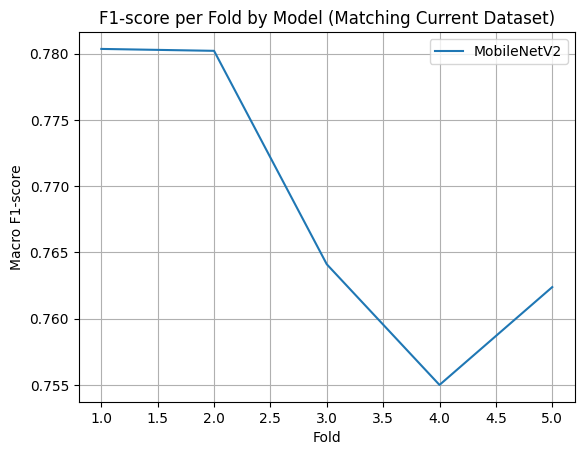

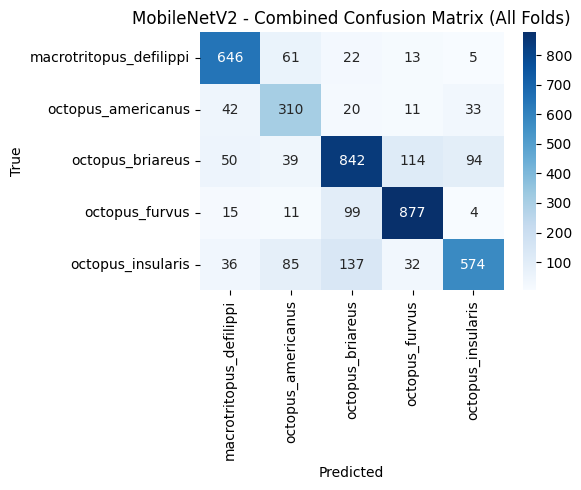


🏆 Best Model: MobileNetV2 (Fold 1, Accuracy: 0.7916)


['/content/drive/MyDrive/OctoMatic_SpeciesID/output/figures/f1_score_by_model.png',
 '/content/drive/MyDrive/OctoMatic_SpeciesID/output/figures/MobileNetV2_combined_confusion_matrix.png']

In [ ]:
import seaborn as sns

# Step 6: Rebuild results from all saved results that match the current dataset hash
results = {}
best_model_info = {'model': None, 'fold': None, 'accuracy': 0}
print("\n\n======== FINAL SUMMARY (Matching Dataset Hash) ========")

for file in os.listdir(OUTPUT_DIR):
    if file.endswith("_results.json"):
        result_path = os.path.join(OUTPUT_DIR, file)
        hash_path = result_path.replace("_results.json", "_dataset_hash.txt")

        # Only load if hash file exists and matches the current dataset
        if os.path.exists(hash_path):
            with open(hash_path) as f:
                saved_hash = f.read().strip()
            if saved_hash == current_dataset_hash:
                with open(result_path) as f:
                    result = json.load(f)
                model_name = file.split("_fold")[0]
                results.setdefault(model_name, []).append(result)

# Summary of valid models
for model_name, folds in results.items():
    accs = [f['accuracy'] for f in folds]
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"{model_name}: Mean Acc = {mean_acc:.4f}, Std = {std_acc:.4f}")

    # Track best model
    for f in folds:
        if f['accuracy'] > best_model_info['accuracy']:
            best_model_info = {
                'model': model_name,
                'fold': f['fold'],
                'accuracy': f['accuracy']
            }

# Plot F1-score per fold
for model_name, folds in results.items():
    f1s = [fold['report']['macro avg']['f1-score'] for fold in folds]
    plt.plot(range(1, len(f1s)+1), f1s, label=model_name)

plt.xlabel('Fold')
plt.ylabel('Macro F1-score')
plt.title('F1-score per Fold by Model (Matching Current Dataset)')
plt.legend()
plt.grid(True)
plt.show()

# Consolidated confusion matrices per model
for model_name, folds in results.items():
    # Sum confusion matrices across all folds
    total_cm = np.sum([np.array(f['confusion_matrix']) for f in folds], axis=0)

    plt.figure(figsize=(6, 5))
    sns.heatmap(total_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=species_names, yticklabels=species_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Combined Confusion Matrix (All Folds)')
    plt.tight_layout()
    plt.show()


# Output best model info
print(f"\n🏆 Best Model: {best_model_info['model']} (Fold {best_model_info['fold']}, Accuracy: {best_model_info['accuracy']:.4f})")

# Save consolidated F1-score and confusion matrix plots to Drive
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Setup
output_dir = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"
plot_dir = os.path.join(output_dir, "figures")
os.makedirs(plot_dir, exist_ok=True)

# Load current dataset hash
def compute_dataset_hash(filepaths):
    import hashlib
    hash_md5 = hashlib.md5()
    for path in sorted(filepaths):
        hash_md5.update(path.encode())
    return hash_md5.hexdigest()

from pathlib import Path

EXTRACT_DIR = "/content/octopus_dataset"
supported_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

image_paths = [
    str(p) for p in Path(EXTRACT_DIR).rglob("*")
    if p.suffix.lower() in supported_exts
]

current_dataset_hash = compute_dataset_hash(image_paths)

# Load species names
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
species_names = sorted(list(set(labels)))

# Aggregate results
results = {}
for file in os.listdir(output_dir):
    if file.endswith("_results.json"):
        result_path = os.path.join(output_dir, file)
        hash_path = result_path.replace("_results.json", "_dataset_hash.txt")

        if os.path.exists(hash_path):
            with open(hash_path) as f:
                saved_hash = f.read().strip()
            if saved_hash == current_dataset_hash:
                model_name = file.split("_fold")[0]
                with open(result_path) as f:
                    res = json.load(f)
                    results.setdefault(model_name, []).append(res)

# Save F1-score plot
plt.figure()
for model_name, folds in results.items():
    f1s = [fold['report']['macro avg']['f1-score'] for fold in folds]
    plt.plot(range(1, len(f1s)+1), f1s, label=model_name)

plt.xlabel('Fold')
plt.ylabel('Macro F1-score')
plt.title('F1-score per Fold by Model (Matching Current Dataset)')
plt.legend()
plt.grid(True)

f1_plot_path = os.path.join(plot_dir, "f1_score_by_model.png")
plt.tight_layout()
plt.savefig(f1_plot_path)
plt.close()

# Save consolidated confusion matrix plots
cm_paths = []
for model_name, folds in results.items():
    total_cm = np.sum([np.array(f['confusion_matrix']) for f in folds], axis=0)

    plt.figure(figsize=(6, 5))
    sns.heatmap(total_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=species_names, yticklabels=species_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Combined Confusion Matrix (All Folds)')
    plt.tight_layout()

    cm_path = os.path.join(plot_dir, f"{model_name}_combined_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    cm_paths.append(cm_path)

[f1_plot_path] + cm_paths



Clean up hashes and check for combatibility

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from collections import defaultdict

# Define safe plot output path in Drive
plot_dir = "/content/drive/MyDrive/OctoMatic_SpeciesID/figures/classification_reports"
os.makedirs(plot_dir, exist_ok=True)

# Helper to compute dataset hash
def compute_dataset_hash(filepaths):
    import hashlib
    hash_md5 = hashlib.md5()
    for path in sorted(filepaths):
        hash_md5.update(path.encode())
    return hash_md5.hexdigest()

# Load dataset + species names using lowercase extension matching
from pathlib import Path

EXTRACT_DIR = "/content/octopus_dataset"  # or wherever your dataset lives
supported_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

image_paths = [
    str(p) for p in Path(EXTRACT_DIR).rglob("*")
    if p.suffix.lower() in supported_exts
]

image_paths = sorted(image_paths)

labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
species_names = sorted(list(set(labels)))
current_dataset_hash = compute_dataset_hash(image_paths)

# Load results for models matching current dataset
output_dir = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"
model_reports = defaultdict(list)

for file in os.listdir(output_dir):
    if file.endswith("_results.json"):
        result_path = os.path.join(output_dir, file)
        hash_path = result_path.replace("_results.json", "_dataset_hash.txt")

        if os.path.exists(hash_path):
            with open(hash_path) as f:
                saved_hash = f.read().strip()

            print(f"🔍 Comparing hash for {file.replace('_results.json', '')}")
            print("  Expected:", current_dataset_hash)
            print("  Found   :", saved_hash)

            if saved_hash == current_dataset_hash:
                model_name = file.split("_fold")[0]
                with open(result_path) as f:
                    res = json.load(f)
                    model_reports[model_name].append(res["report"])


# Plot per-class metrics for each model
for model_name, reports in model_reports.items():
    metrics = {label: {'precision': [], 'recall': [], 'f1-score': []} for label in species_names}

    for report in reports:
        for label in species_names:
            if label in report:
                metrics[label]['precision'].append(report[label]['precision'])
                metrics[label]['recall'].append(report[label]['recall'])
                metrics[label]['f1-score'].append(report[label]['f1-score'])

    labels_order = list(metrics.keys())
    precision_means = [np.mean(metrics[label]['precision']) for label in labels_order]
    recall_means = [np.mean(metrics[label]['recall']) for label in labels_order]
    f1_means = [np.mean(metrics[label]['f1-score']) for label in labels_order]

    x = np.arange(len(labels_order))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, precision_means, width, label='Precision')
    plt.bar(x, recall_means, width, label='Recall')
    plt.bar(x + width, f1_means, width, label='F1-score')

    plt.xticks(x, labels_order, rotation=45, ha="right")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(f"{model_name} - Per-Class Metrics (Mean Across Folds)")
    plt.legend()
    plt.tight_layout()

    save_path = os.path.join(plot_dir, f"{model_name}_per_class_metrics.png")
    plt.savefig(save_path)
    plt.close()

print("✅ Plots saved to:", plot_dir)


🔍 Comparing hash for MobileNetV2_fold1
  Expected: 9f716731526d61c6629e02c17a4b3666
  Found   : 9f716731526d61c6629e02c17a4b3666
🔍 Comparing hash for MobileNetV2_fold2
  Expected: 9f716731526d61c6629e02c17a4b3666
  Found   : 9f716731526d61c6629e02c17a4b3666
🔍 Comparing hash for MobileNetV2_fold3
  Expected: 9f716731526d61c6629e02c17a4b3666
  Found   : 9f716731526d61c6629e02c17a4b3666
🔍 Comparing hash for MobileNetV2_fold4
  Expected: 9f716731526d61c6629e02c17a4b3666
  Found   : 9f716731526d61c6629e02c17a4b3666
🔍 Comparing hash for MobileNetV2_fold5
  Expected: 9f716731526d61c6629e02c17a4b3666
  Found   : 9f716731526d61c6629e02c17a4b3666
✅ Plots saved to: /content/drive/MyDrive/OctoMatic_SpeciesID/figures/classification_reports


Plot per class metrics, classification report

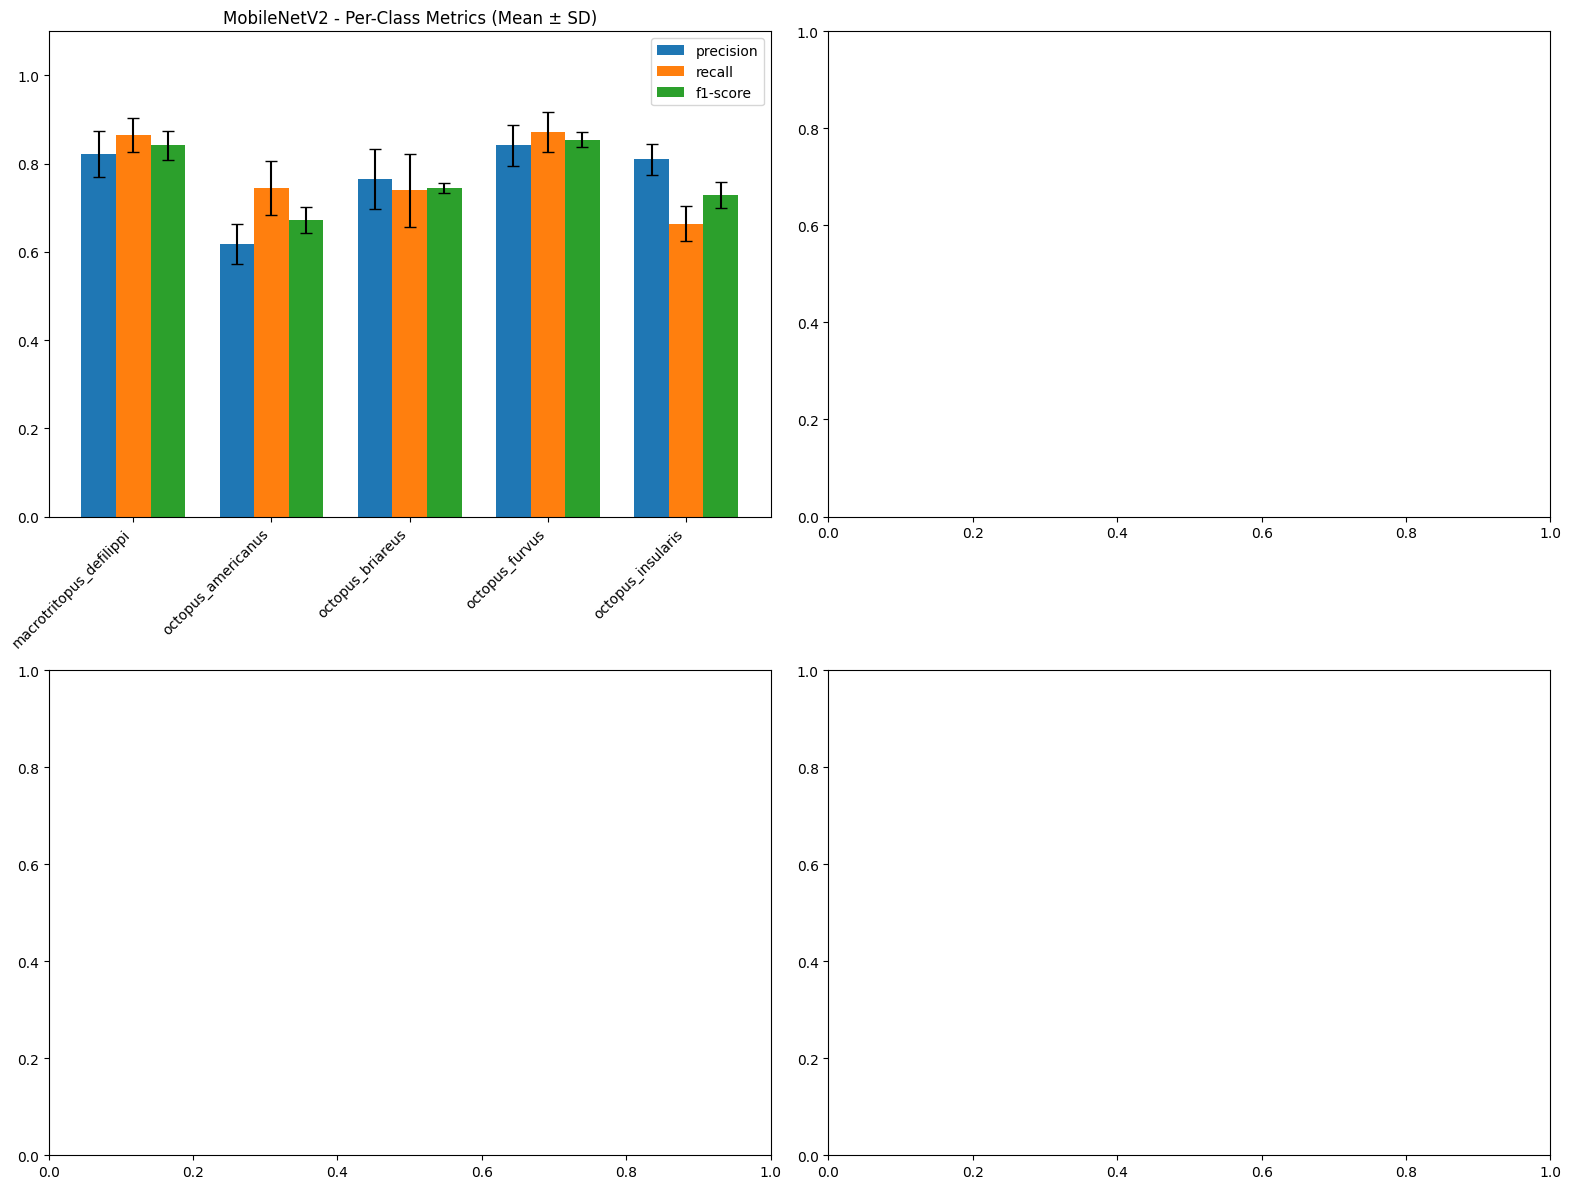

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from glob import glob
from collections import defaultdict

# Setup
output_dir = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"
from pathlib import Path

EXTRACT_DIR = "/content/octopus_dataset"
supported_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

image_paths = [
    str(p) for p in Path(EXTRACT_DIR).rglob("*")
    if p.suffix.lower() in supported_exts
]

labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
species_names = sorted(list(set(labels)))

# Compute dataset hash
def compute_dataset_hash(filepaths):
    import hashlib
    hash_md5 = hashlib.md5()
    for path in sorted(filepaths):
        hash_md5.update(path.encode())
    return hash_md5.hexdigest()

current_dataset_hash = compute_dataset_hash(image_paths)

# Collect model reports
model_reports = defaultdict(list)
for file in os.listdir(output_dir):
    if file.endswith("_results.json"):
        result_path = os.path.join(output_dir, file)
        hash_path = result_path.replace("_results.json", "_dataset_hash.txt")
        if os.path.exists(hash_path):
            with open(hash_path) as f:
                saved_hash = f.read().strip()
            if saved_hash == current_dataset_hash:
                model_name = file.split("_fold")[0]
                with open(result_path) as f:
                    res = json.load(f)
                    model_reports[model_name].append(res["report"])

# Step 1: Gather all means to compute best values per metric/species
all_means = defaultdict(lambda: defaultdict(list))  # species -> metric -> list of means

for reports in model_reports.values():
    metrics = {label: {"precision": [], "recall": [], "f1-score": []} for label in species_names}
    for report in reports:
        for label in species_names:
            if label in report:
                for metric in ["precision", "recall", "f1-score"]:
                    metrics[label][metric].append(report[label][metric])
    for label in species_names:
        for metric in ["precision", "recall", "f1-score"]:
            all_means[label][metric].append(np.mean(metrics[label][metric]))

# Best mean per species & metric
best_values = {
    label: {
        metric: max(all_means[label][metric])
        for metric in all_means[label]
    }
    for label in all_means
}

# # Step 2: Plot
# fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# axes = axes.flatten()
# metric_colors = {"precision": "tab:blue", "recall": "tab:orange", "f1-score": "tab:green"}

# for ax, (model_name, reports) in zip(axes, sorted(model_reports.items())):
#     metrics = {label: {"precision": [], "recall": [], "f1-score": []} for label in species_names}
#     for report in reports:
#         for label in species_names:
#             if label in report:
#                 for metric in metrics[label]:
#                     metrics[label][metric].append(report[label][metric])

#     x = np.arange(len(species_names))
#     width = 0.25
#     for i, metric in enumerate(["precision", "recall", "f1-score"]):
#         means = [np.mean(metrics[label][metric]) for label in species_names]
#         stds = [np.std(metrics[label][metric]) for label in species_names]
#         bars = ax.bar(x + (i - 1) * width, means, width, yerr=stds, capsize=4, label=metric, color=metric_colors[metric])

#         # # Add value labels, rotated, with * for best
#         # for j, bar in enumerate(bars):
#         #     label = species_names[j]
#         #     val = means[j]
#         #     text = f"{val:.2f}"
#         #     if np.isclose(val, best_values[label][metric]):
#         #         text += "*"
#         #     ax.text(
#         #         bar.get_x() + bar.get_width() / 2,
#         #         bar.get_height() / 2,
#         #         text,
#         #         ha="center",
#         #         va="center",
#         #         fontsize=8,
#         #         rotation=90,
#         #         color="white"
#         #     )

#     ax.set_title(f"{model_name} - Per-Class Metrics (Mean ± SD)")
#     ax.set_xticks(x)
#     ax.set_xticklabels(species_names, rotation=45, ha="right")
#     ax.set_ylim(0, 1.1)
#     ax.legend()

# plt.tight_layout()
# summary_plot_path = "/content/drive/MyDrive/OctoMatic_SpeciesID/figures/per_class_metrics_summary.png"
# plt.savefig(summary_plot_path)
# plt.show()



Plot loss curve

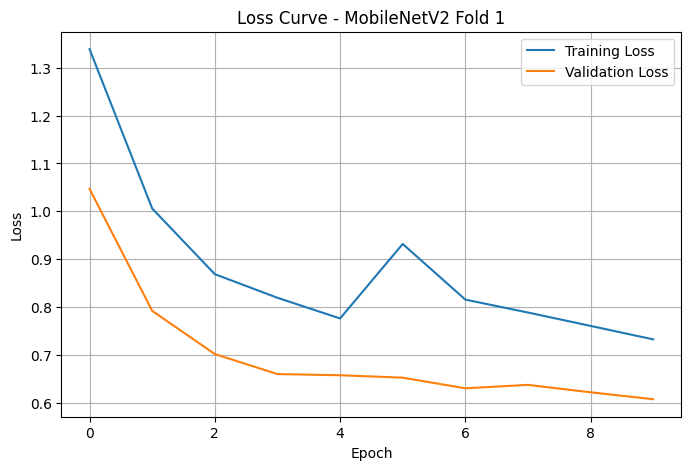

✅ Loss curve saved to: /content/drive/MyDrive/OctoMatic_SpeciesID/figures/loss_curve_best_model.png


In [ ]:
# Plot loss curve for best-performing model

import os
import json
import matplotlib.pyplot as plt

output_dir = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"
figures_dir = "/content/drive/MyDrive/OctoMatic_SpeciesID/figures"
os.makedirs(figures_dir, exist_ok=True)

# Step 1: Find best model and fold by accuracy
best_model = None
best_fold = None
best_acc = 0

for file in os.listdir(output_dir):
    if file.endswith("_results.json"):
        with open(os.path.join(output_dir, file)) as f:
            result = json.load(f)
        if result['accuracy'] > best_acc:
            best_acc = result['accuracy']
            best_model = file.split("_fold")[0]
            best_fold = int(file.split("_fold")[1].split("_")[0])

# Step 2: Load training history
history_path = os.path.join(output_dir, f"{best_model}_fold{best_fold}_history.json")
if not os.path.exists(history_path):
    print("🚫 History file not found for best model. Make sure to save training history during training.")
else:
    with open(history_path) as f:
        history = json.load(f)

    # Step 3: Plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"Loss Curve - {best_model} Fold {best_fold}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    loss_fig_path = os.path.join(figures_dir, "loss_curve_best_model.png")
    plt.savefig(loss_fig_path)
    plt.show()
    print(f"✅ Loss curve saved to: {loss_fig_path}")


In [ ]:
Image Count per Class

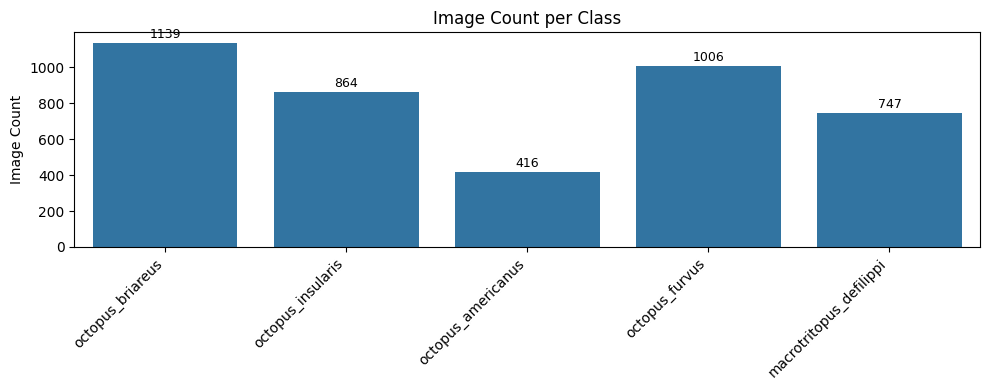

In [ ]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Count images per class
label_counts = Counter(labels)
classes = list(label_counts.keys())
counts = list(label_counts.values())

# Plot barplot
plt.figure(figsize=(10, 4))
ax = sns.barplot(x=classes, y=counts)

# Add count labels above each bar
for i, count in enumerate(counts):
    ax.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom', fontsize=9)

plt.title("Image Count per Class")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()




Macro F1, Loss Curve, Confusion Matrices

✅ Dataset: 4172 images · 5 classes · hash=9f716731526d61c6629e02c17a4b3666


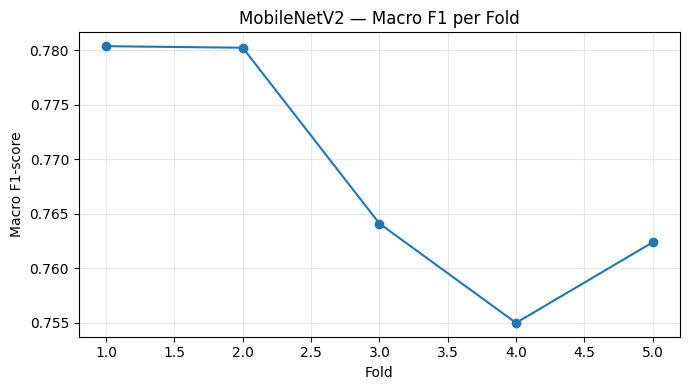

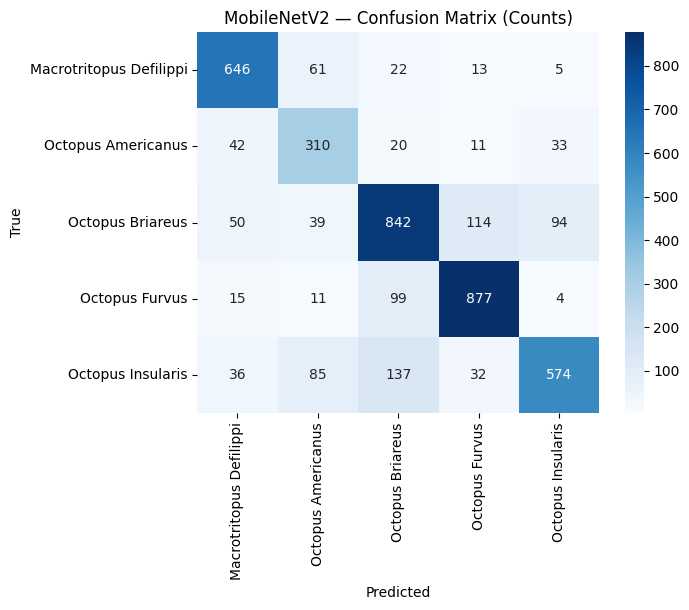

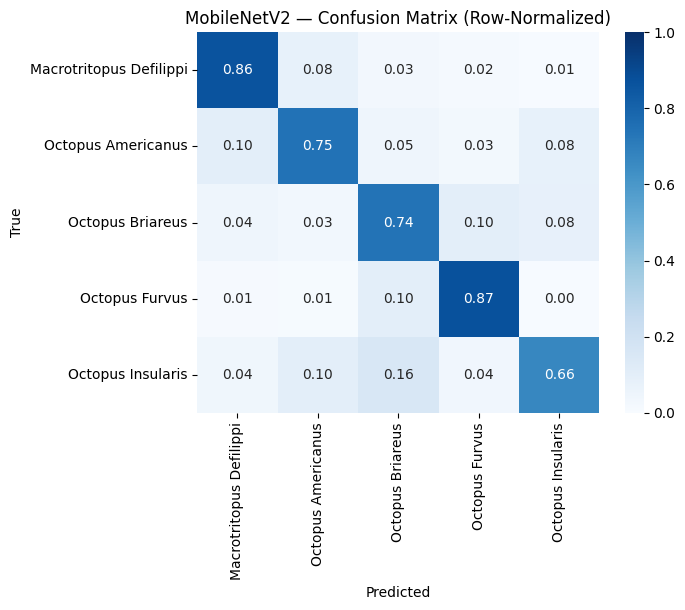

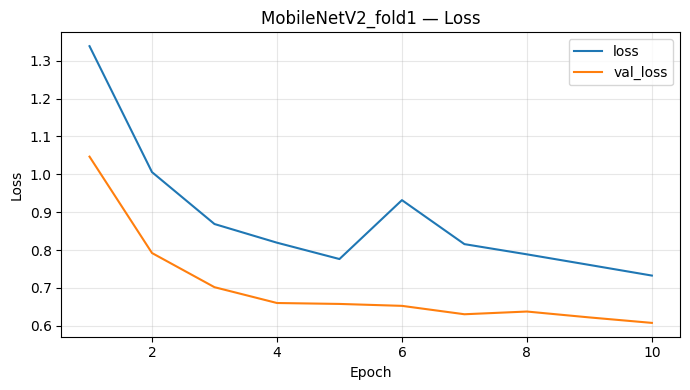

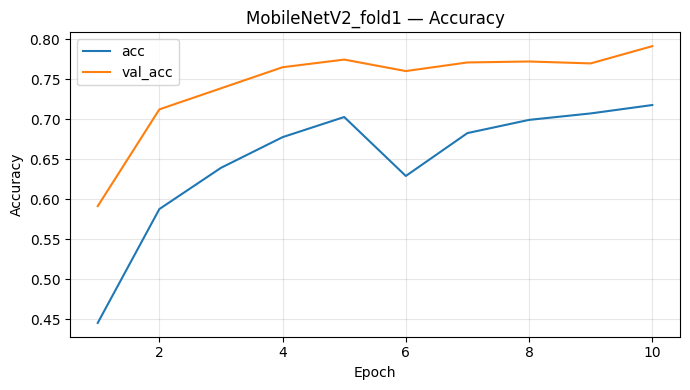

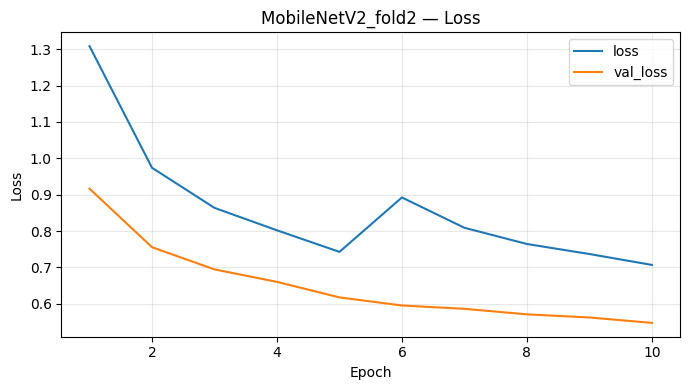

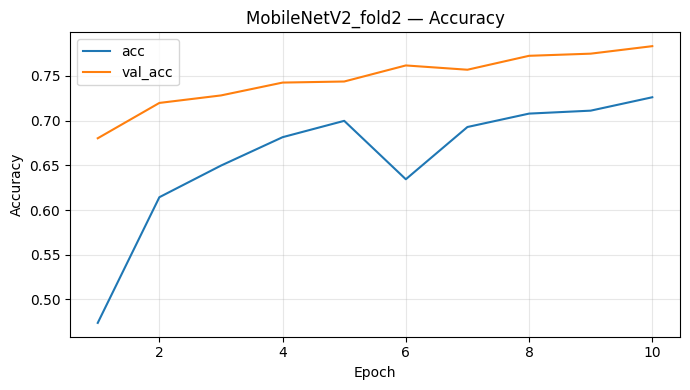

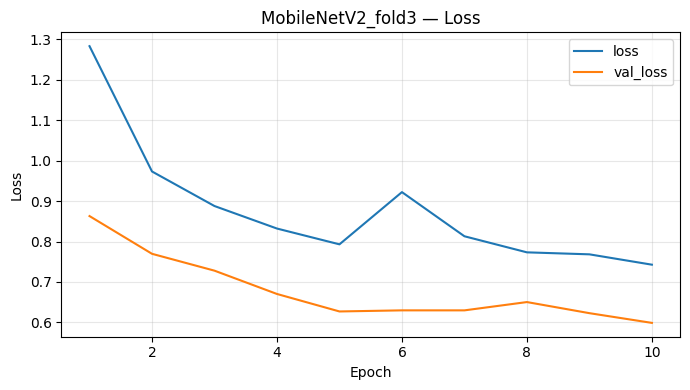

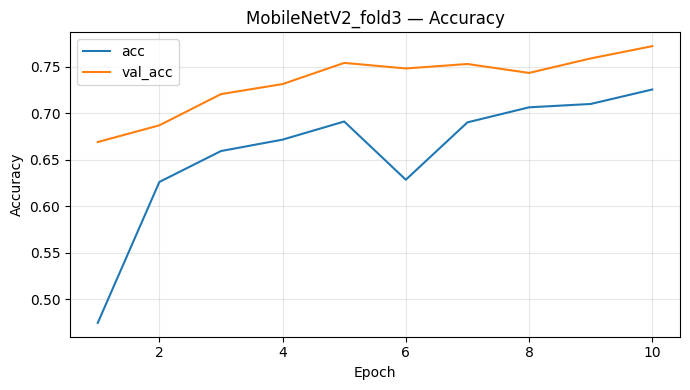

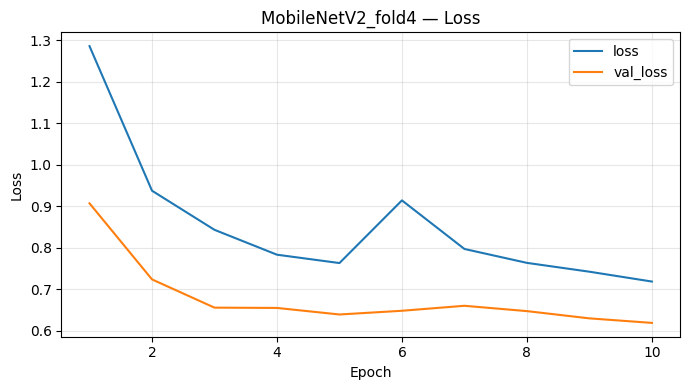

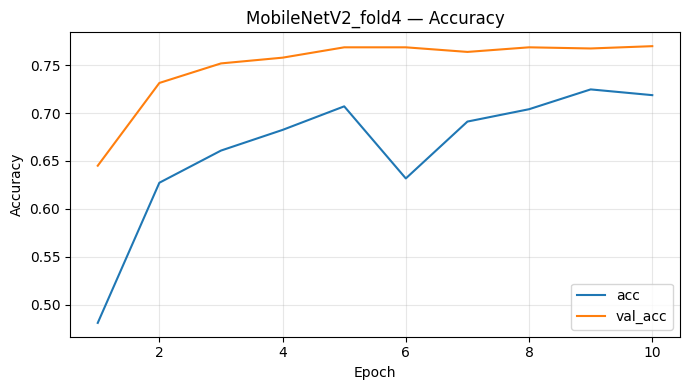

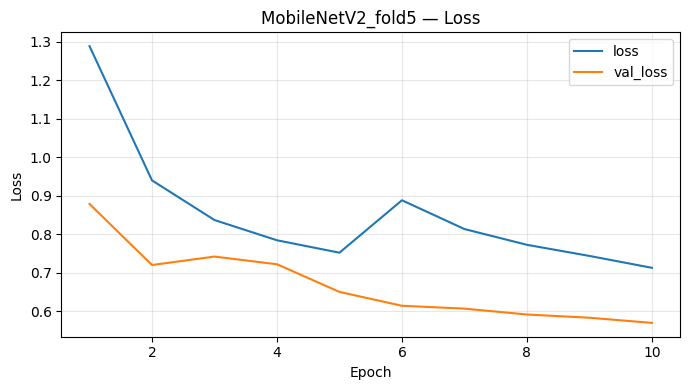

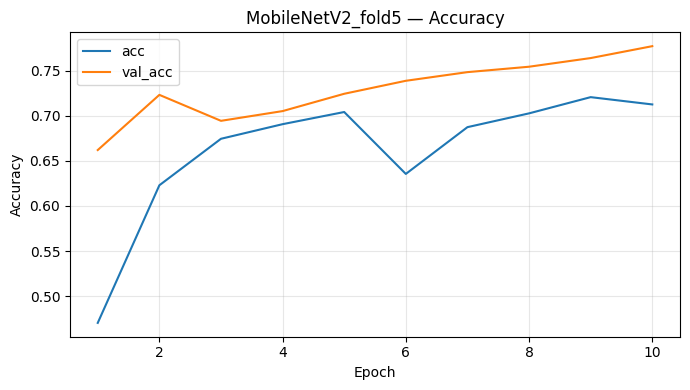


=== Summary Across Models (from combined confusion matrices) ===
         model  folds  overall_accuracy_from_cm  macro_f1_from_cm  \
0  MobileNetV2      5                  0.778763          0.768554   

   weighted_f1_from_cm  mean_val_accuracy  mean_macro_f1_report  
0             0.778237           0.778759              0.768414  

Artifacts saved to: /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds
- MobileNetV2:
    CM (counts): /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_cm_counts.png
    CM (norm):   /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_cm_norm.png
    F1 curve:    /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_f1_per_fold.png
    Per-class:   /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_per_class_metrics.csv
    Summary CSV: /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/summary_across_models.csv


In [ ]:
# ===========================
# OctoMatic — Fold-Aware Evaluation for octomatic.ipynb outputs
# ===========================
import os, json, hashlib, numpy as np, pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

# Try seaborn for nicer heatmaps; fall back to matplotlib-only if missing
try:
    import seaborn as sns
    _HAVE_SNS = True
except Exception:
    _HAVE_SNS = False

# ---- CONFIG: match your notebook paths ----
OUTPUT_DIR  = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"
EXTRACT_DIR = "/content/octopus_dataset"  # folder where images were extracted for training
SAVE_DIR    = os.path.join(OUTPUT_DIR, "eval_figs_folds")
os.makedirs(SAVE_DIR, exist_ok=True)

# ---- Helpers copied from your notebook style ----
def compute_dataset_hash(filepaths):
    md5 = hashlib.md5()
    for p in sorted(filepaths):
        md5.update(p.encode())
    return md5.hexdigest()

def find_image_paths(root):
    supported_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    return [
        str(p) for p in Path(root).rglob("*")
        if p.suffix.lower() in supported_exts
    ]

def heatmap(ax, mat, fmt, title, xticklabels, yticklabels, vmin=None, vmax=None):
    if _HAVE_SNS:
        sns.heatmap(mat, annot=True, fmt=fmt, cmap="Blues",
                    xticklabels=xticklabels, yticklabels=yticklabels,
                    vmin=vmin, vmax=vmax, ax=ax)
    else:
        im = ax.imshow(mat, cmap=matplotlib.colormaps.get_cmap("Blues"), vmin=vmin, vmax=vmax)
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                ax.text(j, i, format(mat[i, j], fmt), ha="center", va="center", fontsize=8)
        ax.set_xticks(range(len(xticklabels))); ax.set_xticklabels(xticklabels, rotation=45, ha="right")
        ax.set_yticks(range(len(yticklabels))); ax.set_yticklabels(yticklabels)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")

# ---- 1) Recompute current dataset hash + species order (exactly like training) ----
image_paths = find_image_paths(EXTRACT_DIR)
if not image_paths:
    raise RuntimeError(f"No images found under {EXTRACT_DIR}. Make sure the dataset is extracted.")
current_dataset_hash = compute_dataset_hash(image_paths)
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
species_names = sorted(pd.Series(labels).unique())
tick_labels = [s.replace("_"," ").title() for s in species_names]
num_classes = len(species_names)
label_to_idx = {name:i for i, name in enumerate(species_names)}

print(f"✅ Dataset: {len(image_paths)} images · {num_classes} classes · hash={current_dataset_hash}")

# ---- 2) Load per-fold results that match the dataset hash ----
# Expected filenames: <Model>_fold<k>_results.json with sibling <Model>_fold<k>_dataset_hash.txt
by_model = {}  # model_name -> list of dicts {'fold', 'accuracy', 'report', 'cm' (np.array)}
for fname in os.listdir(OUTPUT_DIR):
    if not fname.endswith("_results.json"):
        continue
    result_path = os.path.join(OUTPUT_DIR, fname)
    hash_path   = result_path.replace("_results.json", "_dataset_hash.txt")
    if not os.path.exists(hash_path):
        continue
    saved_hash = Path(hash_path).read_text().strip()
    if saved_hash != current_dataset_hash:
        continue  # skip results for a different dataset

    # Parse model + fold
    base = os.path.splitext(fname)[0]  # e.g., MobileNetV2_fold1_results
    if "_fold" not in base:
        continue
    model_name = base.split("_fold")[0]
    try:
        fold_str = base.split("_fold")[1].split("_")[0]
        fold_idx = int(fold_str)
    except Exception:
        fold_idx = None

    with open(result_path, "r", encoding="utf-8") as f:
        res = json.load(f)

    # results structure from your notebook:
    # {'fold': k, 'accuracy': val_acc, 'report': <classification_report dict>, 'confusion_matrix': [[...]]}
    cm = np.array(res.get("confusion_matrix", []), dtype=float)
    if cm.shape != (num_classes, num_classes):
        # try to realign via labels present in report (rarely needed if species order matches)
        rep = res.get("report", {})
        row_labels = [k for k in rep.keys() if k not in ("accuracy","macro avg","weighted avg","micro avg")]
        # If row_labels are strings of class names, attempt to reorder
        if row_labels and len(row_labels) == num_classes:
            # assume report uses species_names order; otherwise, skip with warning
            pass
        else:
            print(f"⚠️ Skipping {fname}: confusion_matrix shape {cm.shape} != {(num_classes, num_classes)}")
            continue

    entry = {
        "fold": fold_idx if fold_idx is not None else res.get("fold"),
        "accuracy": float(res.get("accuracy", np.nan)),
        "report": res.get("report", {}),
        "cm": cm
    }
    by_model.setdefault(model_name, []).append(entry)

if not by_model:
    raise RuntimeError(
        f"No matching *_results.json files found under {OUTPUT_DIR} for current dataset hash."
    )

# ---- 3) For each model: plot F1 per fold, build combined CM, derive metrics, save artifacts ----
summary_rows = []
for model_name, entries in by_model.items():
    entries = sorted(entries, key=lambda d: (d["fold"] if d["fold"] is not None else 1))
    accs = [e["accuracy"] for e in entries]
    macro_f1s = []
    for e in entries:
        rep = e["report"]
        macro_f1s.append(rep.get("macro avg", {}).get("f1-score", np.nan))

    # 3a) F1 per fold
    plt.figure(figsize=(7.0, 4.0))
    xs = [e["fold"] if e["fold"] is not None else (i+1) for i, e in enumerate(entries)]
    plt.plot(xs, macro_f1s, marker="o")
    plt.title(f"{model_name} — Macro F1 per Fold")
    plt.xlabel("Fold"); plt.ylabel("Macro F1-score"); plt.grid(True, alpha=0.3)
    f1_path = os.path.join(SAVE_DIR, f"{model_name}_f1_per_fold.png")
    plt.tight_layout(); plt.savefig(f1_path, dpi=150); plt.show()

    # 3b) Combined confusion matrix (sum over folds)
    cm_total = np.zeros((num_classes, num_classes), dtype=float)
    for e in entries:
        cm_total += e["cm"]

    # counts heatmap
    fig1, ax1 = plt.subplots(figsize=(7.2, 6.2))
    cm_counts_plot = np.rint(cm_total).astype(int)  # <- round then cast to int
    heatmap(ax1, cm_counts_plot, "d",
            f"{model_name} — Confusion Matrix (Counts)",
            tick_labels, tick_labels)
    fig1.tight_layout()
    cm_counts_path = os.path.join(SAVE_DIR, f"{model_name}_cm_counts.png")
    fig1.savefig(cm_counts_path, dpi=150); plt.show()


    # row-normalized heatmap
    row_sums = cm_total.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm_total, row_sums, where=row_sums != 0)
    fig2, ax2 = plt.subplots(figsize=(7.2, 6.2))
    heatmap(ax2, cm_norm, ".2f", f"{model_name} — Confusion Matrix (Row-Normalized)", tick_labels, tick_labels, vmin=0, vmax=1)
    fig2.tight_layout()
    cm_norm_path = os.path.join(SAVE_DIR, f"{model_name}_cm_norm.png")
    fig2.savefig(cm_norm_path, dpi=150); plt.show()

    # 3c) Derive per-class metrics from combined CM (aggregation that actually respects counts)
    tp = np.diag(cm_total)
    per_class_support = cm_total.sum(axis=1)            # true counts (rows)
    pred_support      = cm_total.sum(axis=0)            # predicted counts (cols)
    with np.errstate(divide='ignore', invalid='ignore'):
        recall    = np.where(per_class_support > 0, tp / per_class_support, 0.0)   # sensitivity
        precision = np.where(pred_support      > 0, tp / pred_support,      0.0)
        f1        = np.where((precision+recall) > 0, 2*precision*recall/(precision+recall), 0.0)

    per_class_df = pd.DataFrame({
        "class": tick_labels,
        "support": per_class_support.astype(int),
        "precision": precision,
        "recall": recall,
        "f1": f1
    }).sort_values("class").reset_index(drop=True)

    overall_acc = tp.sum() / cm_total.sum() if cm_total.sum() > 0 else 0.0
    macro_f1 = float(np.mean(f1)) if len(f1) else 0.0
    weighted_f1 = float(np.average(f1, weights=per_class_support)) if per_class_support.sum() > 0 else 0.0

    csv_path = os.path.join(SAVE_DIR, f"{model_name}_per_class_metrics.csv")
    per_class_df.to_csv(csv_path, index=False)

    # save a small text summary
    summary_rows.append({
        "model": model_name,
        "folds": len(entries),
        "mean_val_accuracy": float(np.nanmean(accs)) if accs else np.nan,
        "mean_macro_f1_report": float(np.nanmean(macro_f1s)) if macro_f1s else np.nan,
        "overall_accuracy_from_cm": overall_acc,
        "macro_f1_from_cm": macro_f1,
        "weighted_f1_from_cm": weighted_f1,
        "cm_counts_png": cm_counts_path,
        "cm_norm_png": cm_norm_path,
        "f1_curve_png": f1_path,
        "per_class_csv": csv_path
    })

# ---- 4) Optional: plot training curves for each *_history.json (acc + loss per fold) ----
# You can comment this section out if you don’t need it.
for fname in os.listdir(OUTPUT_DIR):
    if not fname.endswith("_history.json"):
        continue
    hist_path = os.path.join(OUTPUT_DIR, fname)
    with open(hist_path, "r", encoding="utf-8") as f:
        hist = json.load(f)
    epochs = range(1, len(hist.get("loss", [])) + 1)

    # Loss
    plt.figure(figsize=(7.0, 4.0))
    if "loss" in hist:     plt.plot(epochs, hist["loss"], label="loss")
    if "val_loss" in hist: plt.plot(epochs, hist["val_loss"], label="val_loss")
    plt.title(f"{fname.replace('_history.json','')} — Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend()
    lp = os.path.join(SAVE_DIR, f"{fname.replace('.json','')}_loss.png")
    plt.tight_layout(); plt.savefig(lp, dpi=150); plt.show()

    # Accuracy
    if ("accuracy" in hist) or ("val_accuracy" in hist):
        plt.figure(figsize=(7.0, 4.0))
        if "accuracy" in hist:     plt.plot(epochs, hist["accuracy"], label="acc")
        if "val_accuracy" in hist: plt.plot(epochs, hist["val_accuracy"], label="val_acc")
        plt.title(f"{fname.replace('_history.json','')} — Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.grid(True, alpha=0.3); plt.legend()
        ap = os.path.join(SAVE_DIR, f"{fname.replace('.json','')}_accuracy.png")
        plt.tight_layout(); plt.savefig(ap, dpi=150); plt.show()

# ---- 5) Print/save summary across models ----
summary_df = pd.DataFrame(summary_rows).sort_values(
    ["macro_f1_from_cm", "overall_accuracy_from_cm"], ascending=False
)
summary_csv = os.path.join(SAVE_DIR, "summary_across_models.csv")
summary_df.to_csv(summary_csv, index=False)

print("\n=== Summary Across Models (from combined confusion matrices) ===")
print(summary_df[["model","folds","overall_accuracy_from_cm","macro_f1_from_cm","weighted_f1_from_cm","mean_val_accuracy","mean_macro_f1_report"]])

print("\nArtifacts saved to:", SAVE_DIR)
for _, row in summary_df.iterrows():
    print(f"- {row['model']}:")
    print(f"    CM (counts): {row['cm_counts_png']}")
    print(f"    CM (norm):   {row['cm_norm_png']}")
    print(f"    F1 curve:    {row['f1_curve_png']}")
    print(f"    Per-class:   {row['per_class_csv']}")
print(f"    Summary CSV: {summary_csv}")


Calculate ROC and Precision-Recall Curves

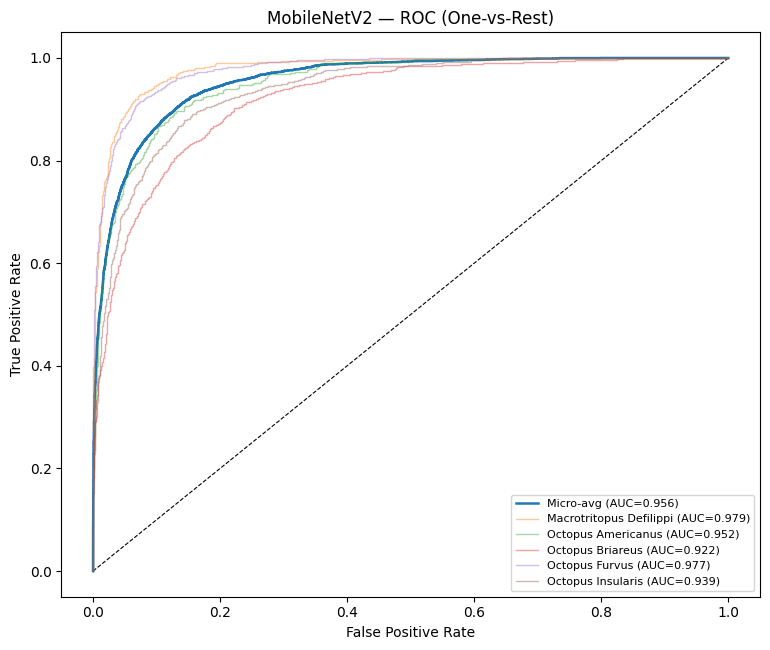

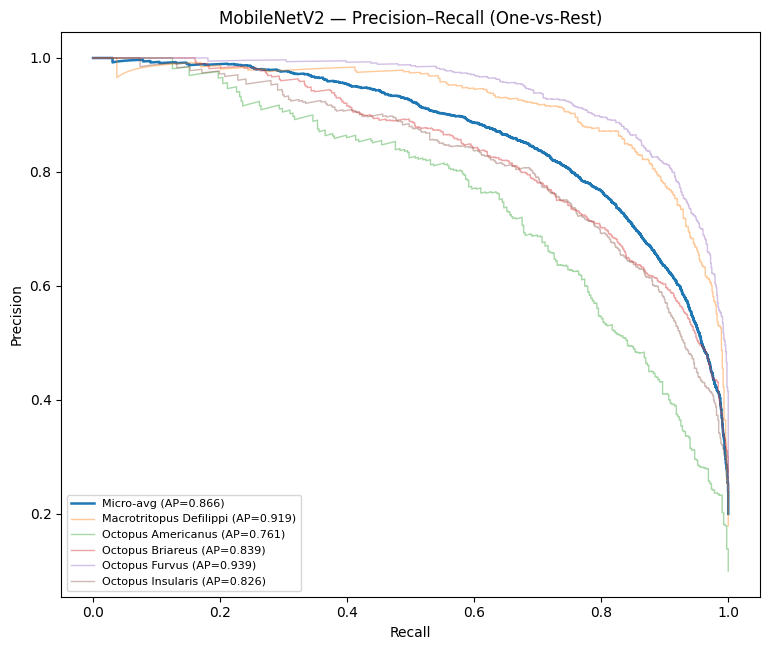

✅ Saved ROC & PR for MobileNetV2:
   • ROC PNG: /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_roc.png
   • AUC CSV: /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_auc.csv
   • PR  PNG: /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_pr.png
   • AP  CSV: /content/drive/MyDrive/OctoMatic_SpeciesID/output/eval_figs_folds/MobileNetV2_ap.csv


In [ ]:
# ===========================
# OctoMatic — ROC + Precision–Recall from *_probs.json (fold-aware)
# ===========================
import os, json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ---- CONFIG ----
OUTPUT_DIR  = "/content/drive/MyDrive/OctoMatic_SpeciesID/output"
EXTRACT_DIR = "/content/octopus_dataset"  # only used if current_dataset_hash not defined
SAVE_DIR    = os.path.join(OUTPUT_DIR, "eval_figs_folds")
os.makedirs(SAVE_DIR, exist_ok=True)

# ---- Helpers ----
def _compute_dataset_hash_if_needed():
    # reuse if defined in the notebook
    try:
        _ = current_dataset_hash  # noqa: F821
        return current_dataset_hash
    except Exception:
        pass
    # compute from file paths (same logic as training)
    import hashlib
    def find_image_paths(root):
        exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
        return [str(p) for p in Path(root).rglob("*") if p.suffix.lower() in exts]
    paths = find_image_paths(EXTRACT_DIR)
    if not paths:
        print(f"⚠️ Could not compute dataset hash (no images under {EXTRACT_DIR}). Skipping hash check.")
        return None
    md5 = hashlib.md5()
    for p in sorted(paths):
        md5.update(p.encode())
    return md5.hexdigest()

ds_hash = _compute_dataset_hash_if_needed()

# Gather *_probs.json per model, filtering by dataset hash when available
by_model = {}  # model_name -> list of dicts
for fname in os.listdir(OUTPUT_DIR):
    if not fname.endswith("_probs.json"):
        continue
    probs_path = os.path.join(OUTPUT_DIR, fname)
    prefix = fname.replace("_probs.json", "")         # e.g. MobileNetV2_fold1
    hash_path = os.path.join(OUTPUT_DIR, f"{prefix}_dataset_hash.txt")
    if ds_hash and os.path.exists(hash_path):
        with open(hash_path, "r") as f:
            saved_hash = f.read().strip()
        if saved_hash != ds_hash:
            continue

    if "_fold" not in prefix:
        continue
    model_name = prefix.split("_fold")[0]
    try:
        fold_idx = int(prefix.split("_fold")[1])
    except Exception:
        fold_idx = None

    with open(probs_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    by_model.setdefault(model_name, []).append({
        "fold": fold_idx,
        "species_names": data["species_names"],
        "y_true": np.asarray(data["y_true"], dtype=int),
        "probs":  np.asarray(data["y_pred_probs"], dtype=float),
        "path": probs_path
    })

if not by_model:
    raise RuntimeError("No matching *_probs.json files found (check OUTPUT_DIR / dataset hash).")

# For each model, concatenate folds, compute ROC + PR, and save PNG + CSV
for model_name, entries in by_model.items():
    entries = sorted(entries, key=lambda d: (d["fold"] if d["fold"] is not None else 1))

    # Ensure species order is consistent across folds; if not, realign columns
    base_names = entries[0]["species_names"]
    name_to_col_ref = {n:i for i,n in enumerate(base_names)}
    ys, ps = [], []
    for e in entries:
        if e["species_names"] != base_names:
            cur_map = {n:i for i,n in enumerate(e["species_names"])}
            reindexed = np.stack([e["probs"][:, cur_map[n]] for n in base_names], axis=1)
            ps.append(reindexed)
        else:
            ps.append(e["probs"])
        ys.append(e["y_true"])
    y_true_all = np.concatenate(ys, axis=0)
    probs_all  = np.concatenate(ps, axis=0)

    n_classes = len(base_names)
    labels_idx = list(range(n_classes))
    pretty = [s.replace("_"," ").title() for s in base_names]

    # One-vs-rest binarization
    y_true_bin = label_binarize(y_true_all, classes=labels_idx)

    # ---------- ROC ----------
    fpr, tpr, aucs = {}, {}, {}
    for i in labels_idx:
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs_all[:, i])
        aucs[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs_all.ravel())
    aucs["micro"] = auc(fpr["micro"], tpr["micro"])
    aucs["macro"] = float(np.mean([aucs[i] for i in labels_idx]))

    plt.figure(figsize=(7.8, 6.6))
    plt.plot([0,1],[0,1], "k--", lw=0.8)
    plt.plot(fpr["micro"], tpr["micro"], lw=1.8, label=f"Micro-avg (AUC={aucs['micro']:.3f})")
    for i, name in enumerate(pretty):
        plt.plot(fpr[i], tpr[i], alpha=0.42, lw=1.0, label=f"{name} (AUC={aucs[i]:.3f})")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} — ROC (One-vs-Rest)")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    roc_path = os.path.join(SAVE_DIR, f"{model_name}_roc.png")
    plt.savefig(roc_path, dpi=150); plt.show()

    auc_rows = [{"class": pretty[i], "auc": float(aucs[i])} for i in labels_idx]
    auc_rows += [{"class": "micro-avg", "auc": float(aucs["micro"])},
                 {"class": "macro-avg", "auc": float(aucs["macro"])}]
    pd.DataFrame(auc_rows).to_csv(os.path.join(SAVE_DIR, f"{model_name}_auc.csv"), index=False)

    # ---------- Precision–Recall ----------
    pr_prec, pr_rec, ap = {}, {}, {}
    # Micro-average PR
    prec_micro, rec_micro, _ = precision_recall_curve(y_true_bin.ravel(), probs_all.ravel())
    ap_micro = average_precision_score(y_true_bin.ravel(), probs_all.ravel())

    # Per-class PR/AP (robust to edge cases with 0 positives)
    for i in labels_idx:
        yi = y_true_bin[:, i]
        pi = probs_all[:, i]
        # If a class has no positives, PR is undefined; handle gracefully
        if yi.sum() == 0:
            pr_prec[i], pr_rec[i] = np.array([1.0]), np.array([0.0])
            ap[i] = np.nan
            continue
        pr_prec[i], pr_rec[i], _ = precision_recall_curve(yi, pi)
        ap[i] = average_precision_score(yi, pi)

    # “macro AP” as mean of per-class AP (ignoring NaNs)
    ap_values = [ap[i] for i in labels_idx if not np.isnan(ap[i])]
    ap_macro = float(np.mean(ap_values)) if ap_values else np.nan

    # Plot PR
    plt.figure(figsize=(7.8, 6.6))
    plt.plot(rec_micro, prec_micro, lw=1.8, label=f"Micro-avg (AP={ap_micro:.3f})")
    for i, name in enumerate(pretty):
        plt.plot(pr_rec[i], pr_prec[i], alpha=0.42, lw=1.0,
                 label=(f"{name} (AP={ap[i]:.3f})" if not np.isnan(ap[i]) else f"{name} (AP=NA)"))
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{model_name} — Precision–Recall (One-vs-Rest)")
    plt.legend(loc="lower left", fontsize=8)
    plt.tight_layout()
    pr_path = os.path.join(SAVE_DIR, f"{model_name}_pr.png")
    plt.savefig(pr_path, dpi=150); plt.show()

    # Save AP table
    ap_rows = [{"class": pretty[i], "average_precision": (None if np.isnan(ap[i]) else float(ap[i]))}
               for i in labels_idx]
    ap_rows += [{"class": "micro-avg", "average_precision": float(ap_micro)},
                {"class": "macro-avg", "average_precision": (None if np.isnan(ap_macro) else float(ap_macro))}]
    pd.DataFrame(ap_rows).to_csv(os.path.join(SAVE_DIR, f"{model_name}_ap.csv"), index=False)

    print(f"✅ Saved ROC & PR for {model_name}:")
    print(f"   • ROC PNG: {roc_path}")
    print(f"   • AUC CSV: {os.path.join(SAVE_DIR, f'{model_name}_auc.csv')}")
    print(f"   • PR  PNG: {pr_path}")
    print(f"   • AP  CSV: {os.path.join(SAVE_DIR, f'{model_name}_ap.csv')}")
